In [1]:
## Loads data into Jupyter session from pickled file

import pickle

deserialized = open("modeldf.pickle","rb")
df = pickle.load(deserialized)

In [2]:
## Assumes 80-20 split under seed 8888 for reproducibility
## Split data into test and training sets

from random import shuffle, seed

def dataSplit(data, testPercent = 0.2, s = 8888):
    seed(s)
    identifiers = list(range(len(data)))
    shuffle(identifiers)
    stop = int(len(data) * testPercent)
    trainIds, testIds = identifiers[stop:], identifiers[:stop]
    return data.iloc[trainIds], data.iloc[testIds]

train, test = dataSplit(df)

In [3]:
train.head()

,Ticket ID,Ticket Created,Date of Issue,Time of Issue,Form,Method,Issue,Caller ID Number,Type of Call or Messge,Advertiser Business Number,...,State,Zip,Location (Target),Area Code (Target),Area Code (Source),Location (Source),Issue DateTime,Offset,Issue DateTime UTC,Time Elapsed
45170,1173633,2016-09-02 00:58:37,09/01/2016,7:46pm,Phone,Wireless (cell phone/other mobile device),Robocalls,949-945-2138,Prerecorded Voice,NaN,...,CT,06830,"(41.000947, -73.656421)",914,949,"(33.573486153846, -117.73371615385)",2016-09-01 19:46:00,-14400.0,2016-09-01 23:46:00,01:12:37
175561,100741,2015-01-26 20:14:22,01/26/2015,11:30am,Phone,Wired,Telemarketing (including do not call and spoof...,818-666-8081,Live Voice,818-666-8081,...,IA,52404,"(41.935555, -91.691484)",319,818,"(34.186115, -118.43554333333)",2015-01-26 11:30:00,-18000.0,2015-01-26 16:30:00,03:44:22
1070318,2517587,2018-05-23 20:52:04,05/23/2018,1:49pm,Phone,Wired,Unwanted Calls,None,Abandoned Calls,916-233-1935,...,CA,95758,"(38.424597, -121.423087)",916,NaN,NaN,2018-05-23 13:49:00,-25200.0,2018-05-23 20:49:00,00:03:04
484910,693520,2015-12-06 02:15:42,12/05/2015,7:45pm,TV,NaN,Loud Commercials,NaN,NaN,NaN,...,NY,14094,"(43.157609, -78.667129)",716,NaN,NaN,2015-12-05 19:45:00,-14400.0,2015-12-05 23:45:00,02:30:42
585677,903066,2016-04-09 00:08:25,04/08/2016,4:00pm,Phone,Wireless (cell phone/other mobile device),Telemarketing (including do not call and spoof...,617-792-5883,Prerecorded Voice,NaN,...,CA,94303,"(37.442789, -122.129574)",650,617,"(42.348581818182, -71.100127272727)",2016-04-08 16:00:00,-25200.0,2016-04-08 23:00:00,01:08:25


In [4]:
## Model Development

## TODO: USE JACOB'S RANDOM FOREST CLASSIFIER TO IMPUTE NULL ENTRIES IN ISSUE COLUMN
## TODO: Create model (most likely Multi-Logistic Classifier) to predict the Method (benchmark ~0.42 R^2 value with Random Forests)

## Temporarily remove all null values in Method and Issue

## By doing this, this removes approximately 3.33% of the original dataset, which adds bias to the overall model.
train = train.dropna(subset=['Issue', 'Method'])


In [5]:
## Construct classifier to predict Area Code of Source

subdf = train.dropna(subset = ['Area Code (Source)'])
subnulls = train[train['Area Code (Source)'].isnull()]
subtrain, subtest = dataSplit(subdf)

## We will store all possible Area Code (Source) values in a list for our LabelEncoder
outputs = subdf['Area Code (Source)'].values

In [6]:
## Construct feature transform class that converts input data into compatiable input for OneHotEncoding

from sklearn.base import BaseEstimator, TransformerMixin

class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        self.categorical = categorical
        self.data = list()
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        for row in X[self.categorical].iterrows():
            self.data.append(list(row[1].values))
        return self.data
    
featTrans = FeatureTransformer(['Form', 'Method', 'Issue', 'Area Code (Target)'])
categoricals = featTrans.transform(subtrain)

In [7]:
## Implements OneHotEncoding on all categorical variables, stores boolean matrix in inputs

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categoricals)
inputs = enc.transform(categoricals)

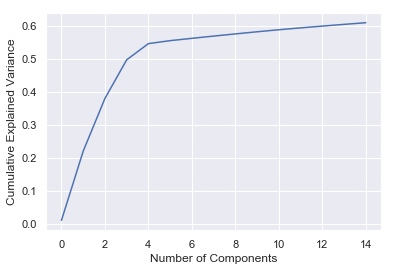

In [8]:
## Implement TruncatedSVD to engineer linear combinations of features to model interplay between categorical features

## PCA is not valid here because the input is sparse.
## It doesn't intuitively make any sense to compute standardization of boolean values.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 15)
svd.fit(inputs)
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

In [9]:
## Use n_components = 4 for SVD and use LabelEncoder to translate data into compatiable format

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 4)
X = svd.fit_transform(inputs)

le = LabelEncoder()
y = le.fit_transform(outputs)



In [10]:
## Use sample of training set to train a RandomForestClassifier (10% of training set)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 10, n_jobs = -1)
indices = np.random.choice(len(X), int(len(X)*0.1))
clf.fit(X[indices], y[indices])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
## Training Error is fairly low (~0.12)...

clf.score(X[indices], y[indices])

0.1262592059595361

In [12]:
## Test Error isn't much better...

categoricals = featTrans.transform(subtest)
inputs = enc.transform(categoricals)
X_test = svd.transform(inputs)
y_test = le.transform(outputs)
indices = np.random.choice(len(X_test), int(len(X_test)*0.1))

clf.score(X_test[indices], y_test[indices])


0.015677377848508447

In [ ]:
## Conclusion: There is no relationship of Area Code (Source) that can be captured from the previously given data.
## This is expected since these phone numbers are most likely randomly generated to hide the true identity of the spammer.
## There is no relationship between the type of call and the observed phone number.